
# Building Job Matrices by Sector

This Jupyter Notebook aims to build job matrices by sector. 



### OD Job Matrices

* import people, trips  and household tables.

In [133]:
from glob import glob

tables = glob('../data/tablas/*.csv')[:-1]
tables

['../data/tablas/synth_people.csv',
 '../data/tablas/synth_households.csv',
 '../data/tablas/od_households.csv',
 '../data/tablas/od_trips.csv',
 '../data/tablas/od_people.csv']

* Merge people, household tables and filter by occupation and employment status, finally aggregate by pair of zones with sum of Expansion Factors.

In [149]:
import pandas as pd

equiv = pd.read_csv('../data/TAZ/equivalence_zones.csv')
mapping = dict(zip(equiv.ZONA, equiv.ZONA3))
map_type = {'F':'formal', 'P':'informal'}
people = pd.read_csv(tables[-1])
household = pd.read_csv(tables[2])
#merge both tables
merged = pd.merge(household, people, on=['HouseholdId'], how='right')
#mapping zones
merged = merged[merged['EmploymentZone'] != 0]
merged['HouseholdZone'] = merged['HouseholdZone'].map(mapping)
merged['EmploymentZone'] = merged['EmploymentZone'].map(mapping)
typeOcc = merged['EmploymentStatus'].unique()[:-1]
#filter and aggregate by pairs of zones
for t in typeOcc:
    merged_type = merged[merged['EmploymentStatus'] == t]
    occs = merged_type['Occupation'].unique()
    print(occs)
    for occ in occs:
        merged_type_occ = merged_type[merged_type['Occupation'] == occ]
        merged_type_occ = merged_type_occ.groupby(['HouseholdZone', 'EmploymentZone'])['ExpansionFactor_y'].sum().reset_index(name='linkages')
        merged_type_occ.rename(columns={'HouseholdZone': 'HomeZone'}, inplace=True)
        merged_type_occ.to_csv(f'../data/JobData/output/{map_type[t]}/{occ}_od.csv', index=False)
        print(f'../data/JobData/output/{map_type[t]}/{occ}_od.csv')

['S' 'M' 'P' 'G']
../data/JobData/output/informal/S_od.csv
../data/JobData/output/informal/M_od.csv
../data/JobData/output/informal/P_od.csv
../data/JobData/output/informal/G_od.csv
['G' 'M' 'P' 'S']
../data/JobData/output/formal/G_od.csv
../data/JobData/output/formal/M_od.csv
../data/JobData/output/formal/P_od.csv
../data/JobData/output/formal/S_od.csv


### Workers by Zone from Synthetic Population

In [150]:
people = pd.read_csv(tables[0])
household = pd.read_csv(tables[1])
#merge both tables
merged = pd.merge(household, people, on=['HouseholdId'], how='right')
#mapping zones
merged['HouseholdZone'] = merged['HouseholdZone'].map(mapping)
typeOcc = merged['EmploymentStatus'].unique()[1:]
print(typeOcc)
for t in typeOcc:
    merged_type = merged[merged['EmploymentStatus'] == t]
    occs = merged_type['Occupation'].unique()
    print(occs)
    for occ in occs:
        merged_type_occ = merged_type[merged_type['Occupation'] == occ]
        merged_type_occ = merged_type_occ.groupby('HouseholdZone')['ExpansionFactor_y'].sum().reset_index(name='Productions')
        merged_type_occ.rename(columns={'HouseholdZone': 'HomeZone'}, inplace=True)
        merged_type_occ.to_csv(f'../data/JobData/output/{map_type[t]}/{occ}_workers.csv', index=False)
        print(f'../data/JobData/output/{map_type[t]}/{occ}_workers.csv')

['P' 'F']
['M' 'G' 'P' 'S']
../data/JobData/output/informal/M_workers.csv
../data/JobData/output/informal/G_workers.csv
../data/JobData/output/informal/P_workers.csv
../data/JobData/output/informal/S_workers.csv
['S' 'P' 'M' 'G']
../data/JobData/output/formal/S_workers.csv
../data/JobData/output/formal/P_workers.csv
../data/JobData/output/formal/M_workers.csv
../data/JobData/output/formal/G_workers.csv


### Jobs by Zone estimated with Denue and Enoe

In [137]:
import pandas as pd
import geopandas as gpd
import json
from glob import glob

equiv = pd.read_csv('../data/TAZ/equivalence_zones.csv')
mapping = dict(zip(equiv.ZONA, equiv.ZONA3))
zonas = gpd.read_file('../data/TAZ/Zonas.shp')
zonas['ZONA'] = zonas['ZONA'].map(mapping)
zonas

,ID,AREA,ZONA,MUNICIPIO,ESTADO,MACROZONA,geometry
0,760,4167.196770,18006,NaN,ZACATECAS,NaN,"POLYGON ((-101.91635 23.77632, -102.37350 24.0..."
1,756,319.306458,18007,NaN,COAHUILA,NaN,"POLYGON ((-100.88482 27.19756, -101.04433 27.3..."
2,759,2385.943600,18008,NaN,DURANGO,NaN,"POLYGON ((-104.04280 25.97775, -104.09193 26.4..."
3,762,130.859070,18004,NaN,NUEVO LEON,NaN,"POLYGON ((-100.75155 26.07842, -100.82457 26.1..."
4,758,101.798401,18009,NaN,COAHUILA,NaN,"POLYGON ((-100.88635 25.57731, -100.94251 25.6..."
...,...,...,...,...,...,...,...
761,727,4.980229,8020,Pesquería,NUEVO LEON,141.0,"POLYGON ((-99.99590 25.73355, -99.99637 25.762..."
762,728,1.030094,8021,Pesquería,NUEVO LEON,141.0,"POLYGON ((-99.96895 25.74568, -99.97014 25.745..."
763,765,89.058762,18003,NaN,NUEVO LEON,NaN,"POLYGON ((-100.04669 26.36693, -100.16183 26.4..."
764,766,791.648682,18012,NaN,ESTADOS UNIDOS DE AMERICA,NaN,"POLYGON ((-98.87310 26.47144, -99.07255 26.610..."


In [138]:
df = pd.read_csv('../data/JobData/denue_inegi_19_.csv', encoding='latin-1')
jobs = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitud, df.latitud), crs=zonas.crs)
jobsByZone = gpd.sjoin(jobs, zonas, op='within')
jobsByZone['codigo_act'] = jobsByZone['codigo_act'].apply(lambda x: int(str(x)[:2]))
mza_NL = gpd.read_file(glob('../data/JobData/nl_inegi/*.shp')[0])
mza_NL['CVE_MZA'] = mza_NL['CVE_MZA'].astype('int')
mza_NL['CVE_MUN'] = mza_NL['CVE_MUN'].astype('int')
mza_NLI = mza_NL.rename(columns={'CVE_MZA':'MZA', 'CVE_AGEB':'AGEB', 'CVE_MUN': 'MUN'}).set_index(['MUN', 'AGEB', 'MZA'])
mza_NLI = gpd.GeoDataFrame(mza_NLI).to_crs(zonas.crs)
# spatial joint between blocks and zones
zonesMza = gpd.sjoin( mza_NLI, zonas,predicate='within').reset_index()
zonesAgebMzaProp = pd.DataFrame(zonesMza.groupby(['ZONA','MUN','AGEB'])['MZA'].count().div(zonesMza.groupby('AGEB')['MZA'].count()))
df = pd.read_csv('../data/JobData/censos.csv')
df = df[df['AGEB'].notna()]
zonesJobs = zonesAgebMzaProp.reset_index().merge(df, left_on='AGEB', right_on = 'AGEB')
#Multiply total of employ with the proportion of blocks for each AGEB and for each zone. 
zonesJobs['tot_emp_prop'] = pd.to_numeric(zonesJobs['Personal Ocupado. Total'].astype(str).str.replace(',',''), errors = 'coerce') * zonesJobs.MZA
#filter rows to only consider total employ for all economic activity by AGEB
zonesJobs['label'] = zonesJobs['Descripción'].apply(lambda x: 'AGEB' in str(x) )
zonesJobs =  zonesJobs[zonesJobs.label ==True]
zonesJobs

/var/folders/5j/44xwpyw56y37sgczrwb3hr1c0000gn/T/ipykernel_87840/3951936271.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/JobData/denue_inegi_19_.csv', encoding='latin-1')
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/var/folders/5j/44xwpyw56y37sgczrwb3hr1c0000gn/T/ipykernel_87840/3951936271.py:13: DtypeWarning: Columns (42,51,53,61,66,69,70,74,76,100) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/JobData/censos.csv')


,ZONA,MUN,AGEB,MZA,Entidad,Municipio,Localidad,Descripción,Unidades Económicas,Personal Ocupado. Total,...,Inversión Total,Formación Bruta de Capital Fijo,Gasto Principal,Ingreso Principal,Margen por reventa de mercancías,"TOTAL de gastos por consumo de bienes y servicios, gastos fiscales, financieros y otros","TOTAL de ingresos por suministro de bienes y servicios, ingresos financieros, subsidios y otros",Otros componentes de la producción,tot_emp_prop,label
0,1,39,0279,0.586207,19,18.0,1.0,AGEB 0279,101,207,...,0,0,27,51,13,34,52,1,121.344828,True
5,1,39,0279,0.586207,19,39.0,1.0,AGEB 0279,78,193,...,1,1,37,74,21,50,81,5,113.137931,True
10,6002,18,0279,0.413793,19,18.0,1.0,AGEB 0279,101,207,...,0,0,27,51,13,34,52,1,85.655172,True
15,6002,18,0279,0.413793,19,39.0,1.0,AGEB 0279,78,193,...,1,1,37,74,21,50,81,5,79.862069,True
20,1,39,0283,0.619048,19,18.0,1.0,AGEB 0283,11,23,...,0,0,3,4,1,3,5,0,14.238095,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14956,17003,1,0017,0.163636,19,1.0,17.0,AGEB 0017,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
14958,17003,1,0017,0.163636,19,1.0,43.0,AGEB 0017,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
14960,17003,1,0017,0.163636,19,1.0,47.0,AGEB 0017,3,176,...,1,1,770,"2,117",4,804,"2,119",1,28.800000,True
14963,17002,1,0021,1.000000,19,1.0,1.0,AGEB 0021,17,32,...,0,0,3,5,2,3,5,0,32.000000,True


In [139]:
denue = pd.read_csv('../data/JobData/denue_by_taz_estimated_informal_from_enoe_ratio.csv')
denue['ZONA'] = denue['ZONA'].map(mapping)
censo_proc = zonesJobs.groupby('ZONA')['tot_emp_prop'].sum()
denue_proc = denue.groupby('ZONA').sum()
merge = denue_proc.merge(censo_proc, on= 'ZONA')
merge

,h,E,min,max,VAR,STD,ratio,informal,tot_emp_prop
ZONA,,,,,,,,,
1,505,3406.246945,1620.0,24070.0,6.965101e+05,1734.724495,4.401540,2498.180654,1788.542909
2,836,5863.543677,3011.0,27945.0,7.037172e+05,109.826960,4.401540,3229.072038,3652.484540
3,888,5679.243921,2493.0,46425.0,1.391660e+06,993.827754,4.401540,3743.025242,2431.102379
4,817,9454.842872,4297.0,108330.0,3.473821e+06,915.297878,4.401540,6646.831686,3546.700460
5,298,2039.151441,1158.0,3235.0,6.626780e+03,135.389119,7.195866,1669.960327,1664.907407
...,...,...,...,...,...,...,...,...,...
16011,170,966.587182,525.0,1530.0,2.478864e+03,139.737635,2.766271,634.163030,2579.869182
17001,4,172.043834,114.0,275.0,1.702091e+03,13.548035,1.740437,36.000344,147.200000
17002,59,294.306703,149.0,490.0,3.075329e+02,17.047363,2.221583,194.476684,70.000000


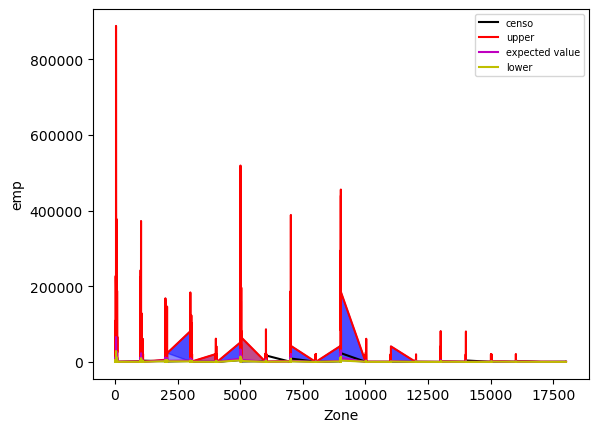

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3
mpld3.enable_notebook()

plt.figure()
plt.plot(merge['tot_emp_prop'],color='black', label='censo')
plt.plot(merge['max'],'-r', label='upper')
plt.plot(merge['E'],color='m', label='expected value')
plt.plot(merge['min'],'-y', label='lower')
# fill the area with black color, opacity 0.15
plt.fill_between(merge.index, merge['max'], merge['min'], where=( merge['tot_emp_prop'] <= merge['max']), color='blue', alpha=0.45,
                 interpolate=True)
plt.fill_between(merge.index, merge['max'], merge['min'], where=( merge['min']<=merge['tot_emp_prop']), color='blue', alpha=0.45,
                 interpolate=True)
plt.fill_between(merge.index, merge['max'], merge['min'], where=( merge['tot_emp_prop'] > merge['max']), color='red', alpha=0.45,
                 interpolate=True)
plt.fill_between(merge.index, merge['max'], merge['min'], where=( merge['min']>merge['tot_emp_prop']), color='red', alpha=0.45,
                 interpolate=True)

plt.xlabel("Zone")
plt.ylabel("emp")
plt.legend(fontsize='x-small')
plt.show()

In [141]:
lab = merge['E'] < merge['tot_emp_prop']
diff = merge[lab]['tot_emp_prop'] - merge[lab]['E'] 
denue['ID'] = denue.index
denue ['E'] = denue['E'].add(denue.groupby('ZONA').max().merge(pd.DataFrame(diff), on = 'ZONA').set_index('ID')[0], fill_value=0)
denue.fillna(0, inplace=True)
denue.set_index('ZONA', inplace=True)


In [142]:
sectors = {'G': ['Transporte y comunicaciones','Agricultura y ganadería', 'Gobierno', 'Otro', 'Minería'],
           'M': ['Industria manufacturera', 'Construcción'],
           'P': ['Comercio'],
           'S': ['Servicios']}
for k in sectors.keys():
    jobs_formal = [denue[denue.sector == s]['E'].reindex(zonas.ZONA, fill_value= 0) for s in sectors[k]]
    print(sum(jobs_formal).max())
    pd.DataFrame(sum(jobs_formal).fillna(0)).reset_index().rename(columns={'ZONA':'EmploymentZone','E':'Attractions'}).to_csv(f'../data/JobData/output/formal/{k}_jobs.csv', index=False)
    jobs_informal = [denue[denue.sector == s]['informal'].reindex(zonas.ZONA, fill_value= 0) for s in sectors[k]]
    print(sum(jobs_informal).max())
    pd.DataFrame(sum(jobs_formal).fillna(0)).reset_index().rename(columns={'ZONA':'EmploymentZone','E':'Attractions'}).to_csv(f'../data/JobData/output/informal/{k}_jobs.csv', index=False)

25421.706825478304
3047.0462114343613
18172.930406409738
7212.1912082449
15136.867475294212
12694.765527699716
33370.20669326703
25511.928979688957
